First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7   
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599  \
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25   
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539  \
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

   

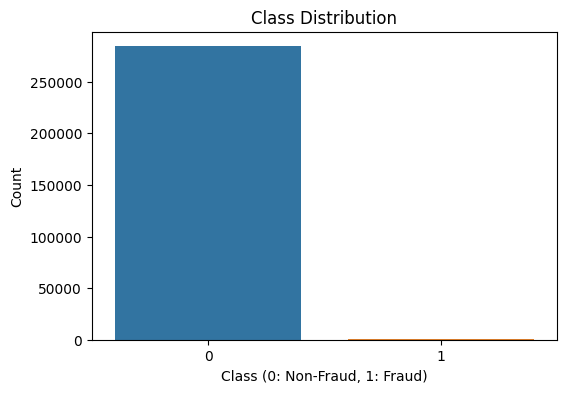

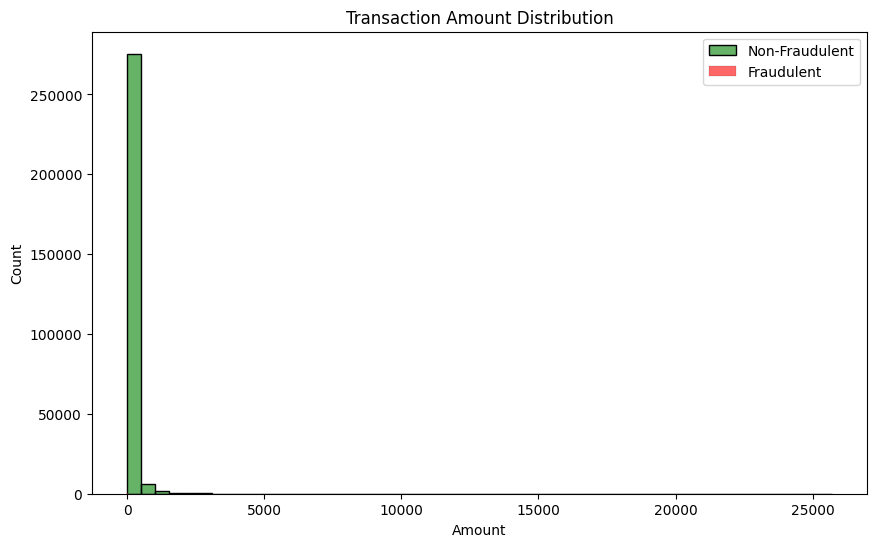

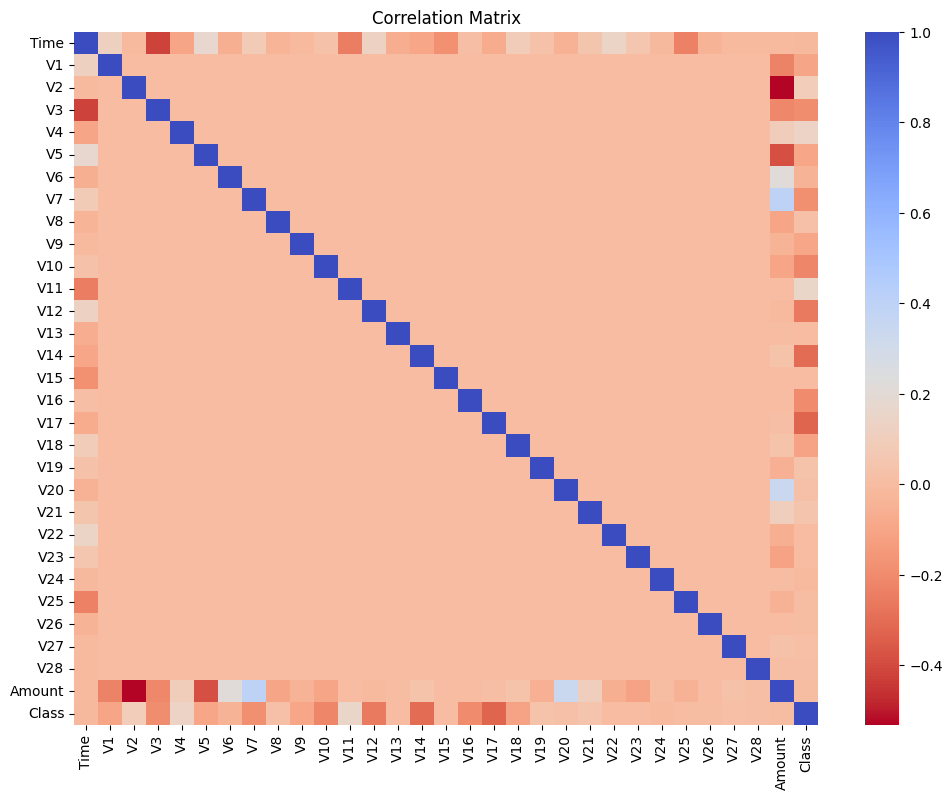


Percentage of fraudulent transactions in the under-sampled dataset:
Class
1    50.0
0    50.0
Name: proportion, dtype: float64
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters found:
{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       146
           1       0.98      0.89      0.93       150

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296



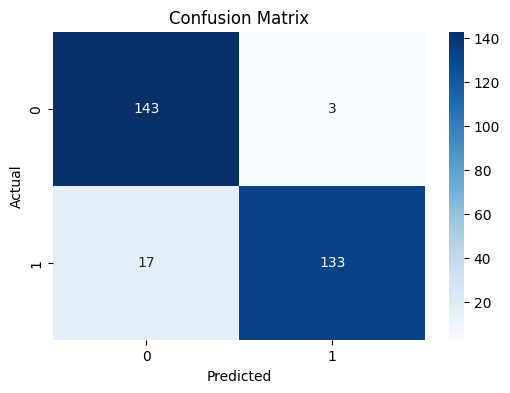

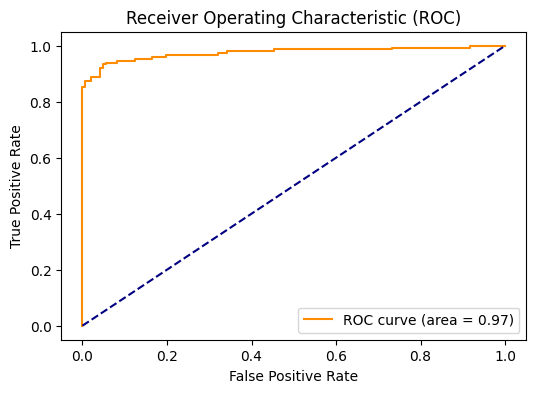

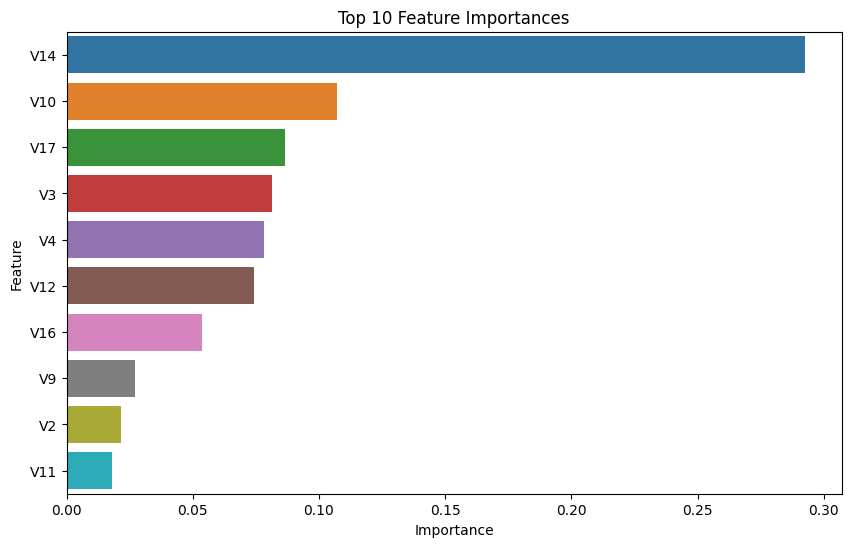

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier


In [ ]:
data = pd.read_csv('/Users/aadithyaram/Downloads/creditcard.csv')

print("First 5 rows of the dataset:")
print(data.head())

print("\nDataset summary:")
print(data.describe())


print("\nMissing values in each column:")
print(data.isnull().sum())


In [ ]:

# Plot the class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.show()

# Plot the amount distribution for fraudulent and non-fraudulent transactions
plt.figure(figsize=(10,6))
sns.histplot(data[data['Class'] == 0]['Amount'], bins=50, color='green', label='Non-Fraudulent', alpha=0.6)
sns.histplot(data[data['Class'] == 1]['Amount'], bins=50, color='red', label='Fraudulent', alpha=0.6)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.legend()
plt.savefig('amount_distribution.png')
plt.show()


In [ ]:

# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr_matrix, cmap='coolwarm_r')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

In [ ]:
# Data Preprocessing
X = data.drop(['Class'], axis=1)
y = data['Class']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Addressing class imbalance using undersampling
fraud_indices = np.array(data[data['Class'] == 1].index)
non_fraud_indices = data[data['Class'] == 0].index


In [ ]:
# Number of fraudulent transactions
number_records_fraud = len(fraud_indices)

# Randomly select non-fraudulent transactions equal to the number of fraudulent transactions
random_non_fraud_indices = np.random.choice(non_fraud_indices, number_records_fraud, replace=False)
random_non_fraud_indices = np.array(random_non_fraud_indices)

# Combine fraudulent and non-fraudulent indices
under_sample_indices = np.concatenate([fraud_indices, random_non_fraud_indices])

# Under-sampled dataset
X_under_sample = X_scaled[under_sample_indices]
y_under_sample = y.iloc[under_sample_indices]

print("\nPercentage of fraudulent transactions in the under-sampled dataset:")
print(y_under_sample.value_counts(normalize=True) * 100)


In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_under_sample, y_under_sample, test_size=0.3, random_state=42
)

# Model Selection
# Initialize a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Cross-validation and Grid Search
# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10]
}

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("\nBest parameters found:")
print(grid_search.best_params_)

# Best estimator
best_rfc = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_rfc.predict(X_test)
y_proba = best_rfc.predict_proba(X_test)[:,1]


In [ ]:

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()